# 1. tool (5 баллов)

В этом блоке вам нужно будет написать две функции для анализа методов приближенного поиска ближайших соседей. Без этих функций использование таких методов довольно затруднительно.

Также, эти функции пригодятся вам при выполнении следующего блока.

Их нужно будет написать в `utils.py`, после чего импортировать в этот ноутбук для использования. Также, в `utils.py` вас ждут некоторые готовые функции, которые пригодятся вам в этой домашке.

Блок будет оцениваться по стандартным tool-правилам. Не забывайте про докстринги, комменты к коду, адекватность. Ориентируйтесь на примеры - они правильные :)

Все что вы напишете в рамках этого задания и все, что уже написано за вас - очень пригодится вам в будущем, обязательно сохраняйте это себе!

## 1.1 `plot_ann_performance` (3 балла)

Нужно написать функцию, которая специальным образом принимает на вход несколько "алгоритмов" приближенного поиска соседей, а также индекс для точного поиска соседей, после чего рисует на графике качество и скорость приближенного поиска для каждого из переданных алгоритмов, а также время построения индексов. Под качеством будем подразумевать `recall@k` - долю правильно найденных k ближайших соседей (сравниваем с точным поиском). Функция подсчета качества вам дана; она также возвращает ошибки, которые вам понадобятся для второй функции. 

Итак, функция должна принимать:
- `build_data`, на которой будут строиться индексы подаваемых на вход алгоритмов
- `query_data`, для которой будут искаться соседи
- `index_dict`: словарик {'index_name': словарик с необходимым*, ...} с необходимой инфой для каждого из исследуемых алгоритмов aNN (см. пример)
- `k` для меры качества
- `flat_build_func`: функция, которая строит Flat-индекс (см. пример)
- `flat_search_func`: функция, которая ищет в Flat-индексе (см. пример)
- `query_in_train`: флаг того, что query_data содержится в build_data. Если это так, мерим качество по k соседям без учета
    ближайшего
- `qps_line`: float. Если указано, нарисуем горизонтальную линию по этому значению
- `recall_line`: float. Если указано, нарисуем вертикальную линию по этому значению
- `title`: str. Если указан, сделать у графика такой title 

Функционал:
- каждый алгоритм задается `fixed_params` и несколькими значениями `speed_param`. Индекс строится по fixed_params, поиск производится с параметром поиска speed_param. Для каждой пары (fixed_params, speed_param_i) у кривой, соотв. индексу, появляется точка на графике.
- эти точки надо подписывать (см. пример) напр. с помощью `ax.annotate`
- скорость поиска измеряется в queries / sec
- нужно отрисовать линию скорости FlatIndex
- нужно вывести в отдельный ax время построения каждого из индексов (напр. в виде barplot)


Остальное:
- сложнее понять задание, чем написать функцию :)
- примеры `build_func`, `search_func` находятся в `index.py`. Там же следует писать и остальные требуемые функции подобного рода. Их вам нужно будет дописывать по мере движения вниз по домашке. Что-то понадобилось - написали.
- в этой домашке в качестве Flat индекса всегда будем передавать `faiss.IndexFlat[L2/IP]`
- не забывайте удалять уже ненужные индексы - они занимают память
- это ничего, что speed_params налазят друг на друга на графике
- следите за размером шрифтов и линий

In [2]:
from utils.utils import plot_ann_performance, analyze_ann_method
from utils.index import *
from functools import partial
import numpy as np


import warnings
warnings.filterwarnings('ignore')
from os import cpu_count

%load_ext autoreload
%autoreload 2

n = 10000
dim = 25

np.random.seed(911)
X = np.random.randn(n, dim)

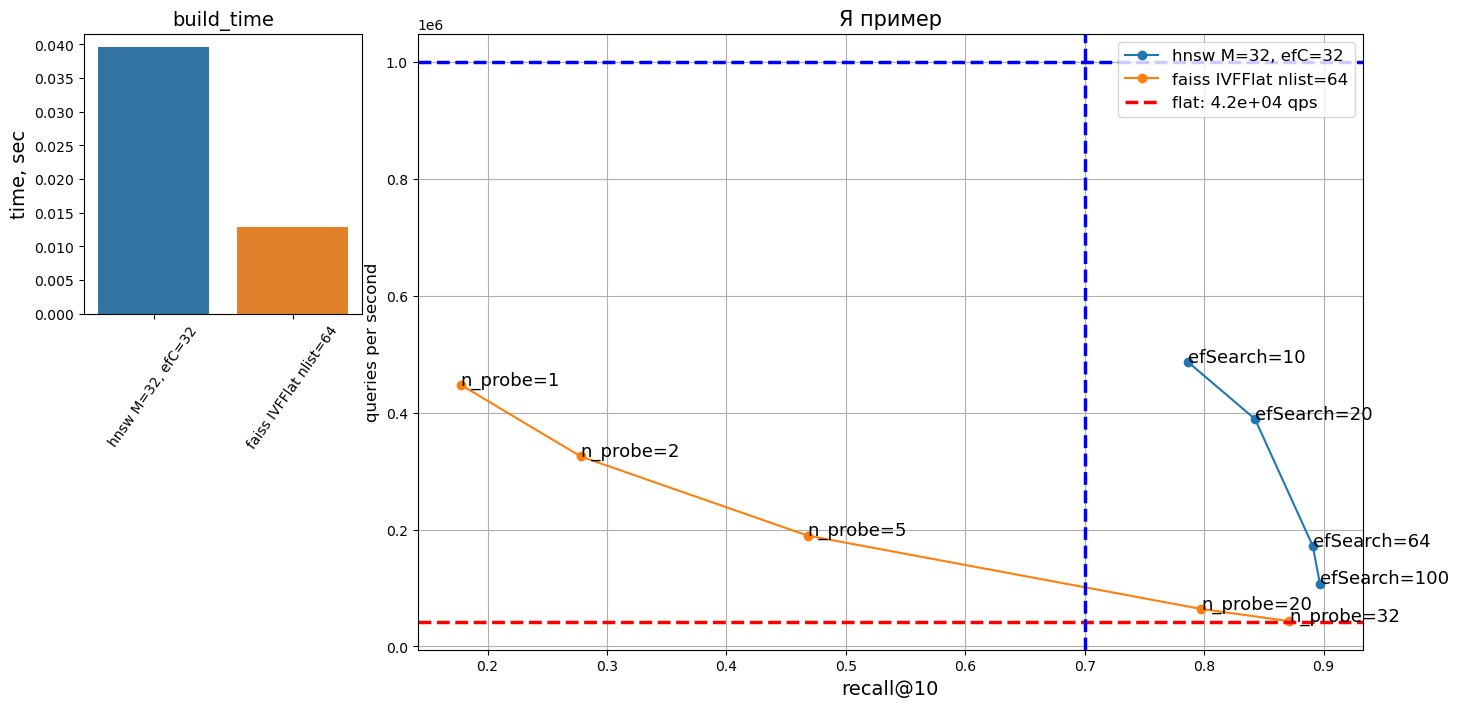

In [2]:
# # ПРИМЕР, НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ

# index_dict = {
#     'hnsw M=32, efC=32': {
#         'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
#         'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
#         'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
#         'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
#     }, 
#     'faiss IVFFlat nlist=64': {
#         'fixed_params': {
#             'dim': dim,
#             'coarse_index': faiss.IndexFlatL2(dim), 
#             'nlist': 64,
#             'metric': faiss.METRIC_L2,
#             'num_threads': 1
#         },
#         'build_func': build_IVFFlat,
#         'search_param': ('n_probe', [1, 2, 5, 20, 32]),
#         'search_func': search_faiss
#     },
# }


# plot_ann_performance(
#     build_data=X,
#     query_data=X[:1000],
#     index_dict=index_dict,
#     k=10,
#     flat_build_func=partial(build_flat_l2, dim=dim), # функция, которая строит FlatIndex - индекс, который просто сохраняет
#     flat_search_func=search_flat, # ... данные, а при поиске осуществляет полный перебор ~ ищет точных соседей
#     query_in_train=True,
#     title='Я пример',
#     qps_line=1e6,
#     recall_line=0.7
# )

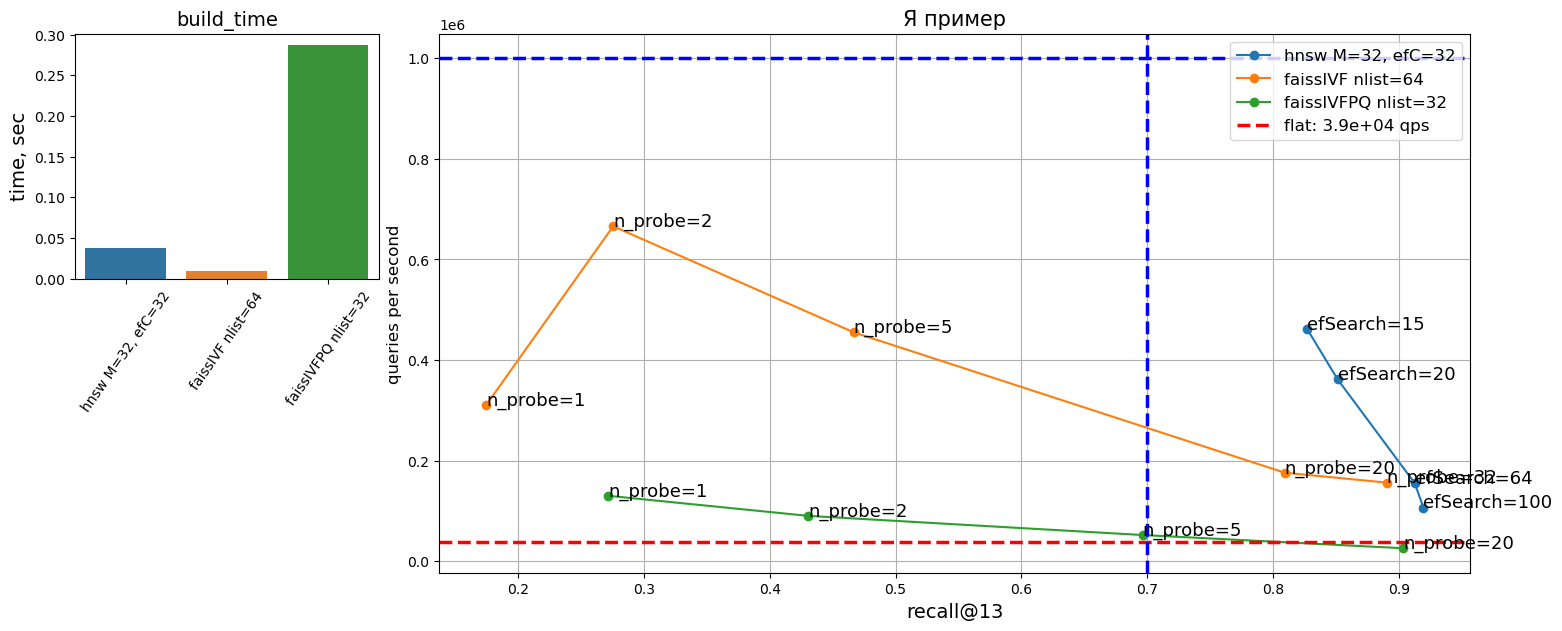

In [3]:
# В качестве примера работы вашей функции, добавьте в index_dict еще какой-нибудь faiss.IndexIVFPQ с l2 метрикой
    # с разными nprobe и запустите с теми же аргументами

%autoreload 2

index_dict = {
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [15, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    }, 
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': cpu_count()
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=32' : {
        'fixed_params' : {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 16,
            'm' : 25,
            'nbits' : 8,
            'metric': faiss.METRIC_L2,
            'num_threads': cpu_count()
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [1, 2, 5, 20]),
        'search_func': search_faiss
    }
}


plot_ann_performance(
    build_data=X,
    query_data=X[:1000],
    index_dict=index_dict,
    k=13,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    title='Я пример',
    qps_line=1e6,
    recall_line=0.7
)

## 1.2 `analyze_ann_method` (2 балла)

Нужно написать функцию, которая специальным образом принимает на вход один алгоритм приближенного поиска соседей, после чего рисует на графике распределение количества ошибок для этого алгоритма. Под алгоритмом понимается фиксированная пара (index, search_param).
Функция `calc_recall` для каждого объекта из query_data подсчитывает, сколько ошибочных соседей было найдено для этого объекта, после чего возвращает эти ошибки, если ее попросить. Используйте это.

Аргументы можете наблюдать в примере.

Функционал:
- распределение ошибок
- подписать бины (напр. `barContainer = ax.bar(...)` -> `ax.bar_label(barContainer, ...)`)
- чистые нули отобразить чем-то отрицательным
- где-нибудь разместить информацию о времени построения индекса, скорости поиска и качестве (см. пример - легенда)

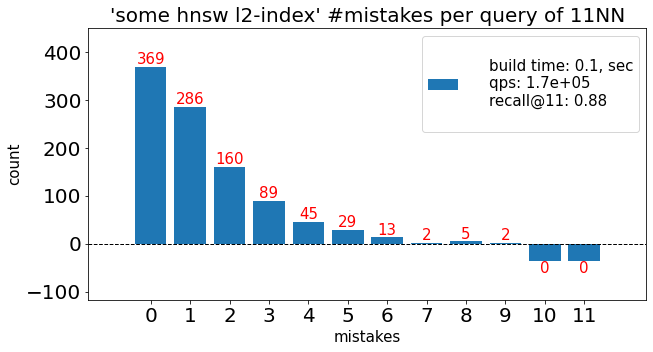

In [4]:
# ПРИМЕР, НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ

analyze_ann_method(
    build_data=X,
    query_data=X[:1000],
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32}),
    search_func=partial(search_hnsw, efSearch=10),
    k=11,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    index_name='some hnsw l2-index'
)

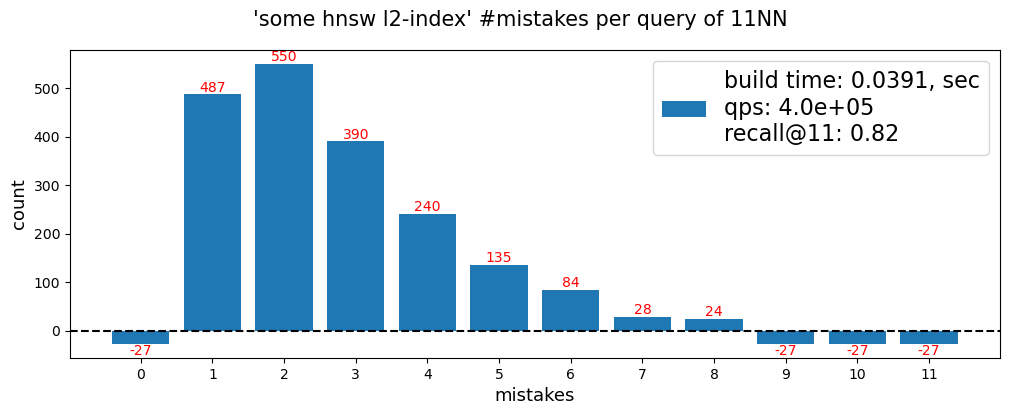

In [4]:
# В качестве примера работы вашей функции можете запустить на тех же аргументах

%autoreload 2

analyze_ann_method(
    build_data=X,
    query_data=X[:1000],
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32}),
    search_func=partial(search_hnsw, efSearch=15),
    k=11,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=True,
    index_name='some hnsw l2-index'
)

# 2. Кейсы (4 балла)

В данном блоке вам предстоит "решить" три кейса (мини-задачки с разными датасетами), используя написанные инструменты.
Задания даны под каждым кейсом. Оценивается как правильность решения, так и адекватность рассуждений.


В этом ноутбуке следует приводить только те графики / ячейки / куски кода, которые вам нужны для конечных рассуждений. Любая исследовательская работа, напрямую не относящаяся к вашим словам, должна быть выполенена в другом ноутбуке, который тоже нужно прикрепить. На другой ноутбук можно ссылаться вроде "Я много чего протестировал (см. ноутбук research), там все плохо было, а вот ХОРОШО уже тут...".

Для начала запустите ячейки ниже - там функция, которая подгружает необходимые данные.

In [1]:
# !pip install h5py

In [5]:
import numpy as np
import h5py
from urllib.request import urlretrieve
import os

def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test'])

## 2.1 GloVe

Датасет содержит векторы-представления некоторых слов

In [7]:
tr, tst = get_ann_benchmark_data('glove-25-angular')
dim=tr.shape[1]
tr.shape, tst.shape

((1183514, 25), (10000, 25))

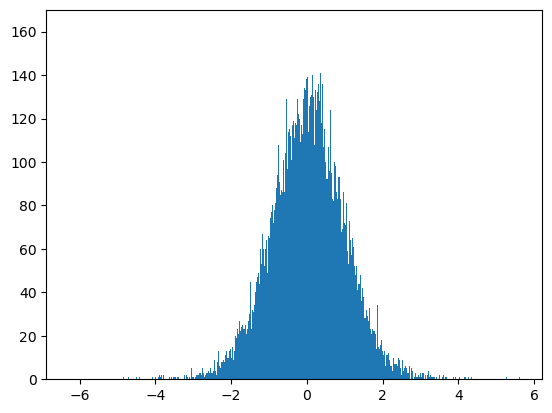

In [8]:
import matplotlib.pyplot as plt

plt.hist(tr[:1000].ravel(), bins=1000)
plt.show()

**Задание:**

Представьте, что вам будут поступать онлайн-запросы с векторами такой же природы (полученными из слов тем же образом). Запросы поступают батчами, вам нужно для каждого батча в режиме реального времени возвращать 10 ближайших из трейна соседей по евклидовой метрике. Запросов очень много, они поступают непрерывно.


Вам нужно построить оптимальные индексы на тренировочных данных, решающие задачу и удовлетворяющие требованию:
1. минимальная скорость на возврат соседей равна `10 * flat_l2_qps` queries / sec `(один индекс для этого требования)`
2. получить максимальное качество соседей (все, что лучше recall@10=0.99 считаем за идеальное качество) `(и один индекс для этого требования)`


- считаем, что памяти дано столько, сколько доступно лично вам при выполнении этой домашки
- "сдать" индекс надо "сегодня", поэтому "максимальное" время построения индекса - примерно 5-6 минут

Доступные индексы, которые могут стать ответом: `faiss.IndexFlat[L2/IP]`, `faiss.IndexIVFFlat`, `faiss.IndexIVFPQ`, `hnswlib.Index`


<br><br>
Используйте функцию `plot_ann_performance`, чтобы определить, какой индекс лучше всего подойдет для какой задачи.
Обычно, параметры для построения индекса и поиска по нему имеют понятную интуицию трейдоффа между скоростью построения индекса, скоростью поиска, качеством найденных соседей и памятью, поэтому использовать что-то вроде optuna для подбора этих параметров - overkill, вы быстро нащупаете нужные диапазоны по графикам. Для попытки нащупать оптимальные параметры, можно использовать сэмпл меньшего размера из трейна в качестве build_data и из теста в качестве query_data, однако конечные выводы должны основываться на графиках, полученных на всех данных трейна и на достаточном количестве query-данных, чтобы оценить queries_per_second. 


Опишите эти два индекса и причины, по которым вы сделали выбор:
- приведите необходимые графики
- напишите свои рассуждения и выводы
- проверьте адекватность распределения кол-ва ошибок - согласуется ли оно с интуицией?
- опишите также свои мысли на тему остальных индексов в контексте каждого из требований <br>


Например: "Для второй задачи лучше всего подойдет `faiss.IndexIVFPQ, nlist=1024, m=4, nbits=8`, потому что ..."


Рекомендации и интуицию по параметрам смотрите тут:
- hnsw:
    - https://github.com/nmslib/nmslib/blob/master/manual/methods.md
    - https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    - https://www.pinecone.io/learn/series/faiss/hnsw/

- faiss:
    - https://github.com/facebookresearch/faiss/wiki/

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
faissIVF nlist=64 || n_probe=32: 100%|██████████| 4/4 [00:44<00:00, 11.20s/it]
faissIVF nlist=1024 || n_probe=256: 100%|██████████| 4/4 [00:18<00:00,  4.50s/it]
faissIVFPQ nlist=256 || n_probe=32: 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]
faissIVFPQ nlist=1024 || n_probe=256: 100%|██████████| 6/6 [00:35<00:00,  5.85s/it]


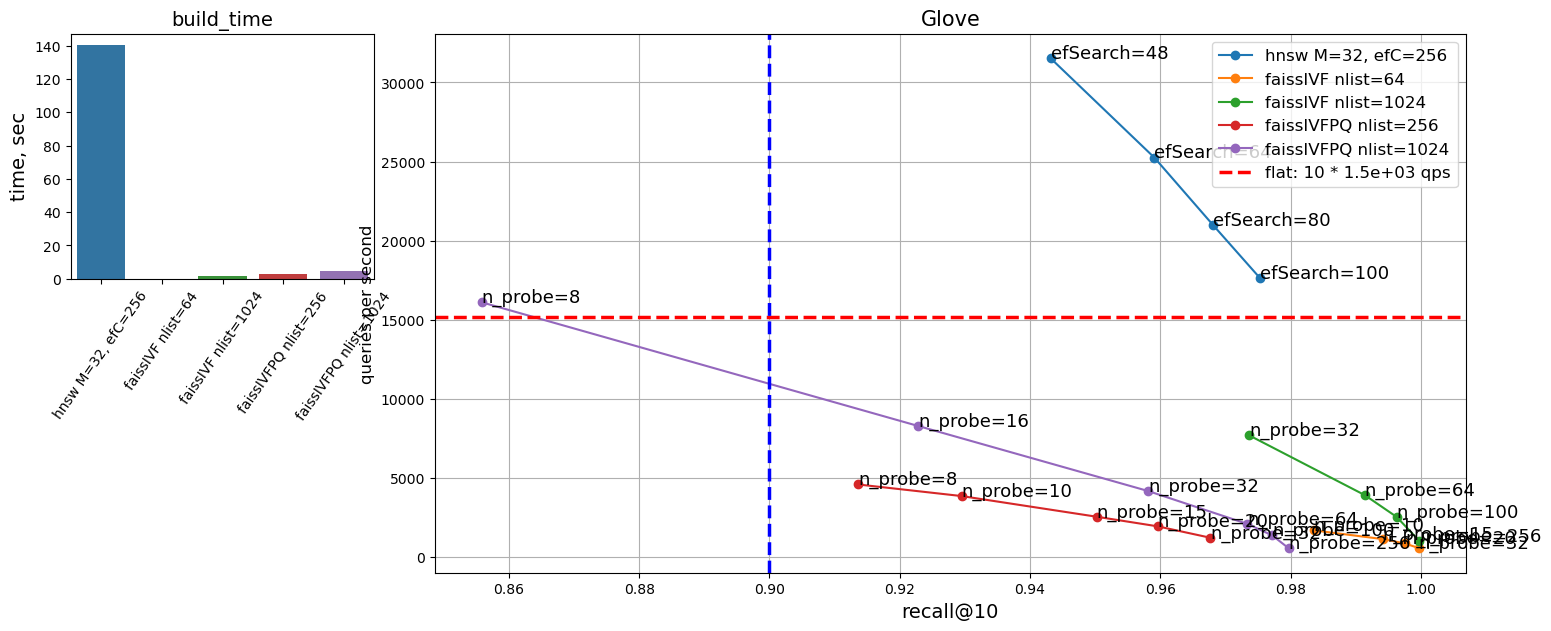

In [11]:
# your code here

%autoreload 2

index_dict = {
    'hnsw M=32, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [48, 64, 80, 100]),
        'search_func': search_hnsw
    },


    'faissIVF nlist=64': {
        'fixed_params': {'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'metric': faiss.METRIC_L2, 'num_threads': cpu_count(), 
            'nlist': 64
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [10, 15, 20, 32]),
        'search_func': search_faiss
    },
    'faissIVF nlist=1024': {
        'fixed_params': {'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'metric': faiss.METRIC_L2, 'num_threads': cpu_count(), 
            'nlist': 1024
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [32, 64, 100, 256]),
        'search_func': search_faiss
    },


    'faissIVFPQ nlist=256' : {
        'fixed_params' : {'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'm' : 25, 'nbits' : 8, 'metric': faiss.METRIC_L2, 'num_threads': cpu_count(),
            'nlist': 256
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [8, 10, 15, 20, 32]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=1024' : {
        'fixed_params' : {'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'm' : 25, 'nbits' : 8, 'metric': faiss.METRIC_L2, 'num_threads': cpu_count(),
            'nlist': 1024
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [8, 16, 32, 64, 100, 256]),
        'search_func': search_faiss
    }
}



plot_ann_performance(
    build_data=tr,
    query_data=tst,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='Glove',
    recall_line=0.9,
    verbose=True,
)

 - Как видно по графику faissX медленный и не удовлетворяет требуемой скорости, поэтому берем hnsw. Как видно, ```hnsw M=32, efC=256, efSearch=100``` редко ошибается и более чем в 10 раз быстрее обычного knn. Поэтому берем его

## 2.2 NYTimes

Датасет содержит векторы-представления некоторых текстов

In [21]:
tr, tst = get_ann_benchmark_data('nytimes-256-angular')
dim = 256
tr.shape, tst.shape

((290000, 256), (10000, 256))

**Задание:**
Постановка задачи та же, но в этом блоке вам надо ответить только на один вопрос - какую меру близости выбрать: евклидову или косинусную.

Проанализируйте с помощью `plot_ann_performance` и анализа распределения ошибок поведение `faiss.IndexIVFFlat`, `hnswlib.Index` на обеих мерах близости на build-подвыборке в 20k, 50k сэмплов и полной build-выборке.

- [как построить IndexFlat для косинусной меры близости](https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances)

Напишите все свои рассуждения, подкрепляя их графиками, и ответьте на поставленный вопрос.

In [17]:
# 2 алгоритма с 2-мя различными параметрами с 2 различными метриками 

%autoreload 2

index_dict_l2 = {
    'hnsw M=32, efC=256': {'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256},'build_func': build_hnsw,'search_param': ('efSearch', [12, 24, 48, 64, 80, 100]),'search_func': search_hnsw},
    'hnsw M=32, efC=32': {'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},'build_func': build_hnsw,'search_param': ('efSearch', [12, 24, 48, 64, 80, 100]),'search_func': search_hnsw},

    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim, 
            'coarse_index': faiss.IndexFlatL2(dim), 
            'metric': faiss.METRIC_L2, 
            'num_threads': cpu_count(), 
            'nlist': 1024 
        },
        'build_func': build_IVFFlat, 
        'search_param': ('n_probe', [10, 15, 20, 32]),
        'search_func': search_faiss
    },
    'faissIVF nlist=64': {
        'fixed_params': {
            'dim': dim, 
            'coarse_index': faiss.IndexFlatL2(dim), 
            'metric': faiss.METRIC_L2, 
            'num_threads': cpu_count(), 
            'nlist': 1024 
        },
        'build_func': build_IVFFlat, 
        'search_param': ('n_probe', [10, 15, 20, 32]),
        'search_func': search_faiss
    },
}

index_dict_cossine = {
    'hnsw M=32, efC=256': {
        'fixed_params': {
            'dim': dim, 
            'space': 'cosine', 
            'M': 32, 
            'ef_construction': 256
        },
        'build_func': build_hnsw,
        'search_param': ('efSearch', [12, 24, 48, 64, 80, 100]),
        'search_func': search_hnsw, 
        'is_cosine' : True
    },
    'hnsw M=32, efC=32': {'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 32, 'ef_construction': 32},'build_func': build_hnsw,'search_param': ('efSearch', [12, 24, 48, 64, 80, 100]),'search_func': search_hnsw, 'is_cosine' : True
    },

    'faissIVF nlist=1024': {
        'fixed_params': {
            'dim': dim, 
            'coarse_index': faiss.IndexFlatIP(dim), 
            'metric': faiss.METRIC_INNER_PRODUCT, 
            'num_threads': cpu_count(),
            'nlist': 1024 
        }, 
        'build_func': build_IVFFlat, 
        'search_param': ('n_probe', [10, 15, 20, 32]), 
        'search_func': search_faiss, 
        'is_cosine' : True
    },
    'faissIVF nlist=64': {'fixed_params': {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(),     'nlist': 64},'build_func': build_IVFFlat,'search_param': ('n_probe', [4, 10, 15, 20]),'search_func': search_faiss, 'is_cosine' : True
    },
}

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]
hnsw M=32, efC=32 || efSearch=100: 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]
WARNING clustering 20000 points to 1024 centroids: please provide at least 39936 training points
faissIVF nlist=1024 || n_probe=32: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
WARNING clustering 20000 points to 1024 centroids: please provide at least 39936 training points
faissIVF nlist=64 || n_probe=32: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


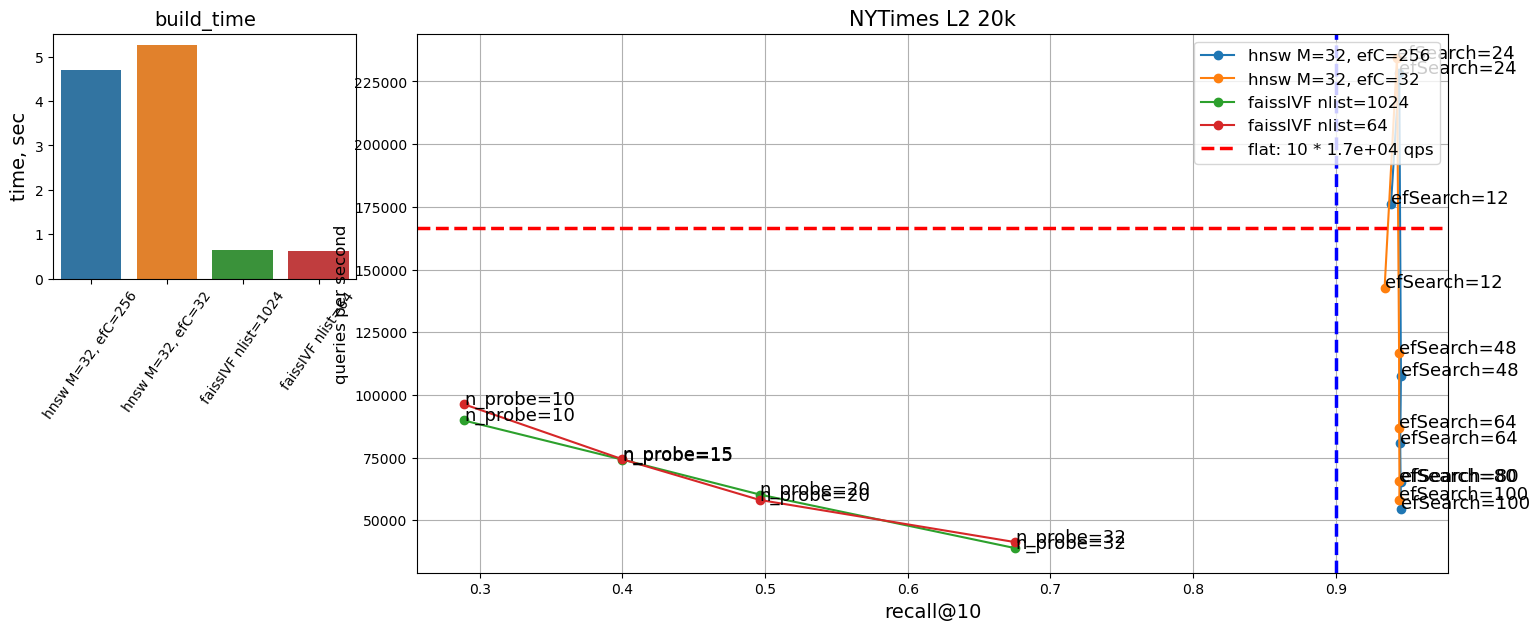

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
hnsw M=32, efC=32 || efSearch=100: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
WARNING clustering 20000 points to 1024 centroids: please provide at least 39936 training points
faissIVF nlist=1024 || n_probe=32: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]
faissIVF nlist=64 || n_probe=20: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


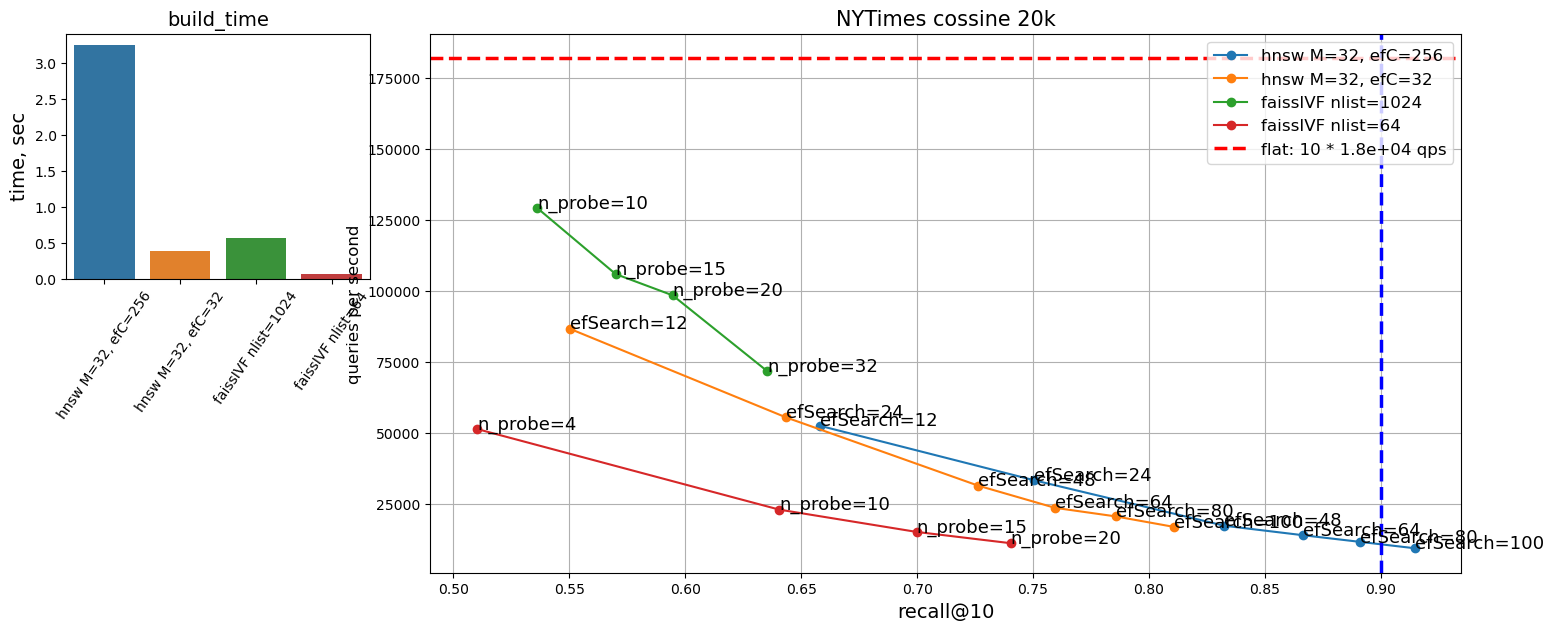

In [18]:
%autoreload 2

X_xk = tr[:20_000]

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_l2,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='NYTimes L2 20k',
    recall_line=0.9
)

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_cossine,
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_cosine,   
    query_in_train=False,
    title='NYTimes cossine 20k',
    recall_line=0.9
)

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]
hnsw M=32, efC=32 || efSearch=100: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]
faissIVF nlist=1024 || n_probe=32: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
faissIVF nlist=64 || n_probe=32: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


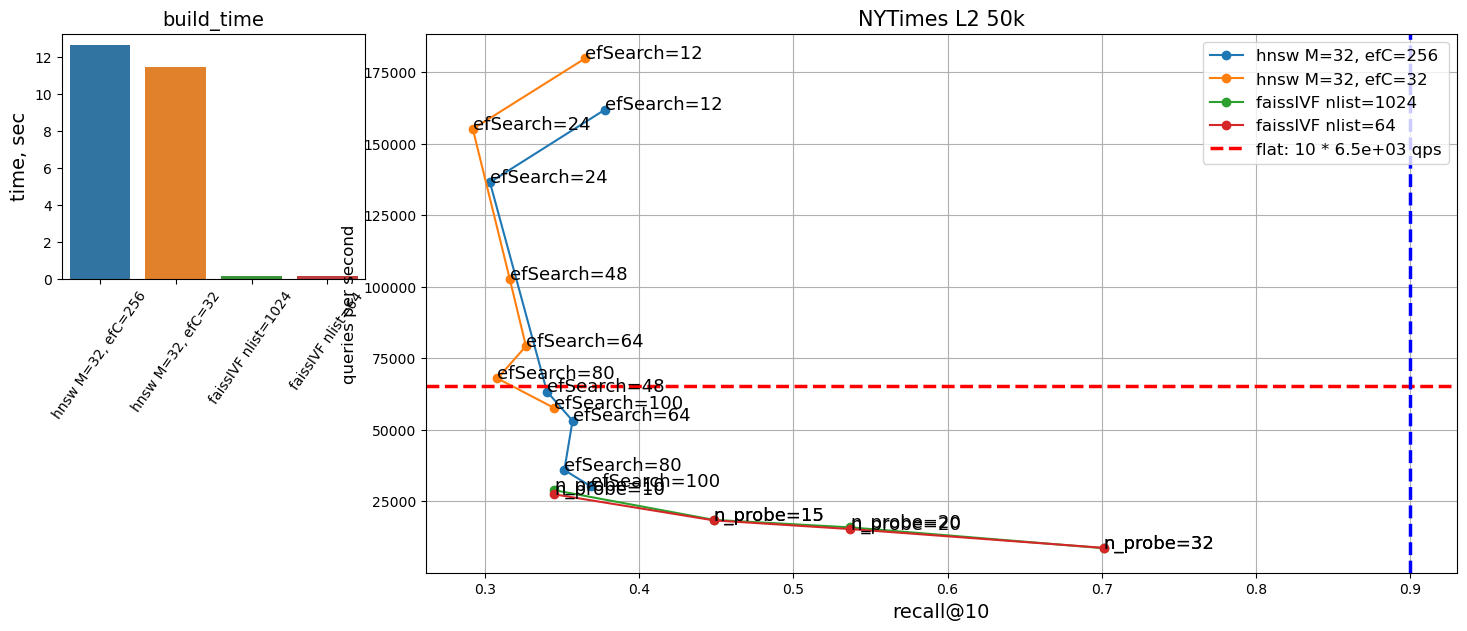

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]
hnsw M=32, efC=32 || efSearch=100: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]
faissIVF nlist=1024 || n_probe=32: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]
faissIVF nlist=64 || n_probe=20: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


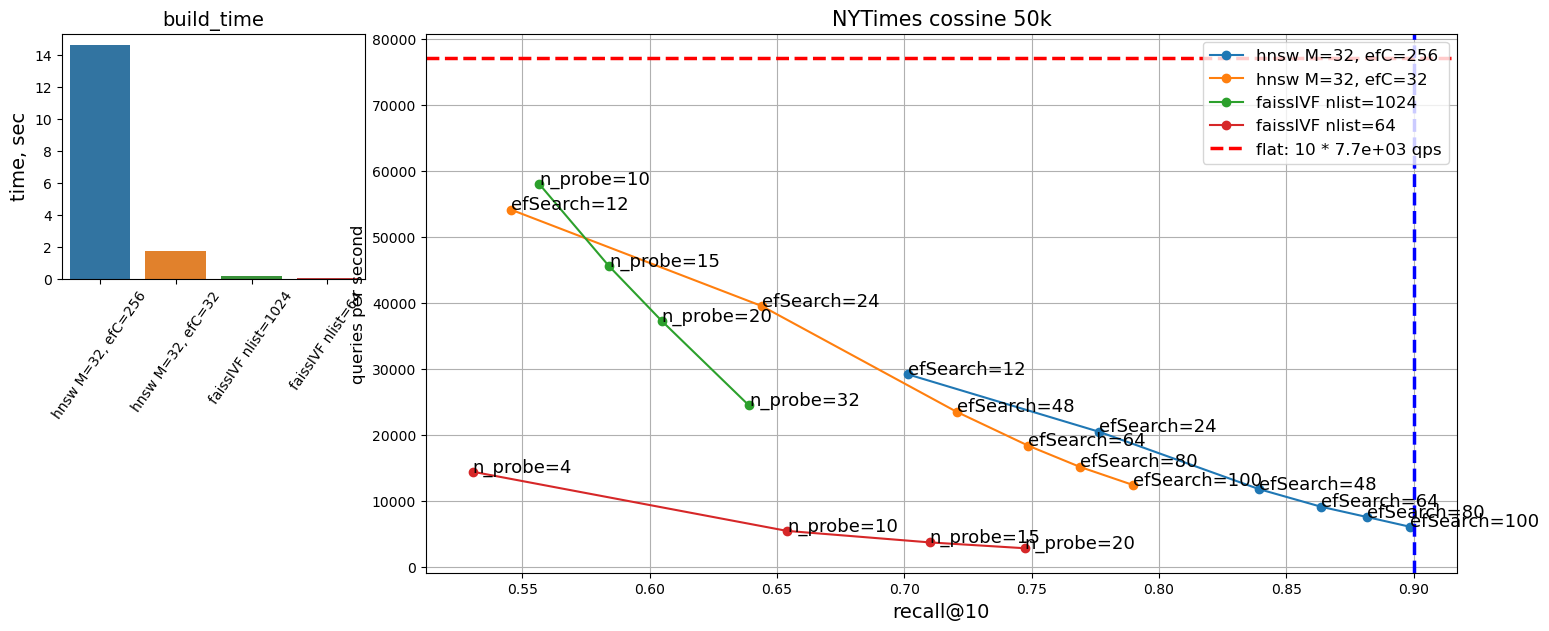

In [19]:
%autoreload 2

X_xk = tr[:50_000]

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_l2,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='NYTimes L2 50k',
    recall_line=0.9
)

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_cossine,
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_cosine, 
    query_in_train=False,
    title='NYTimes cossine 50k',
    recall_line=0.9
)

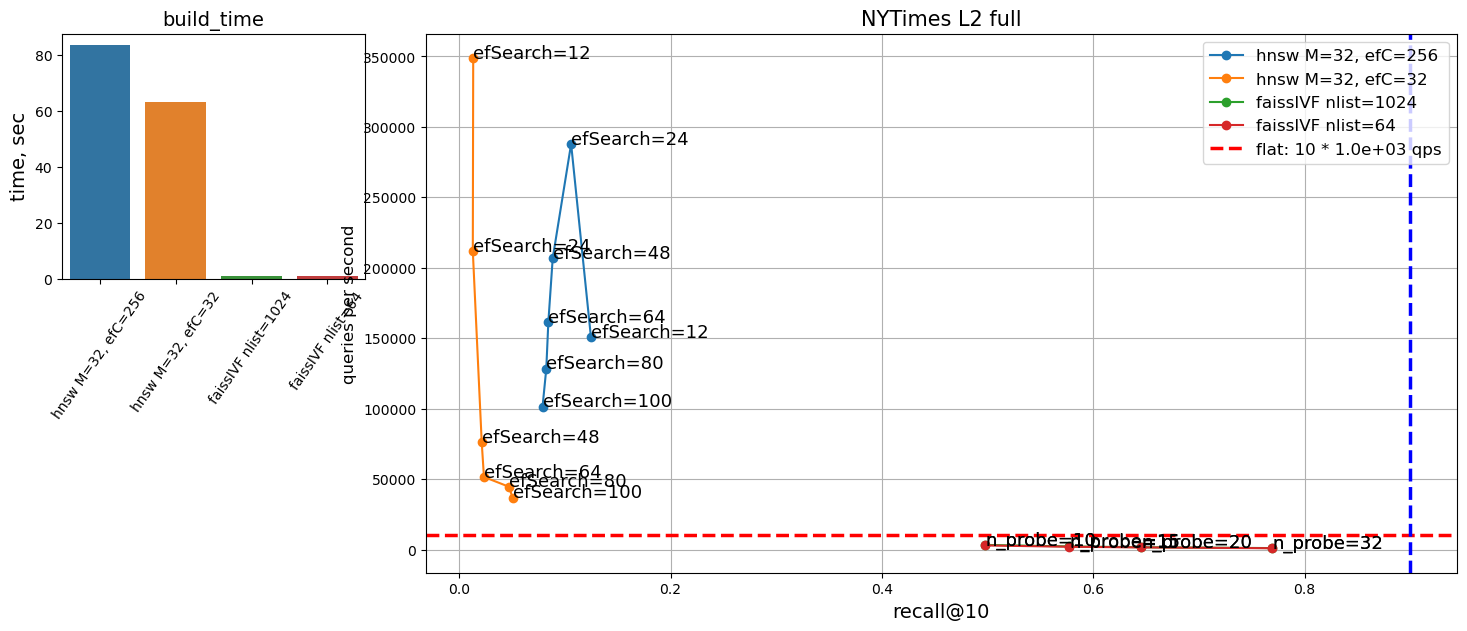

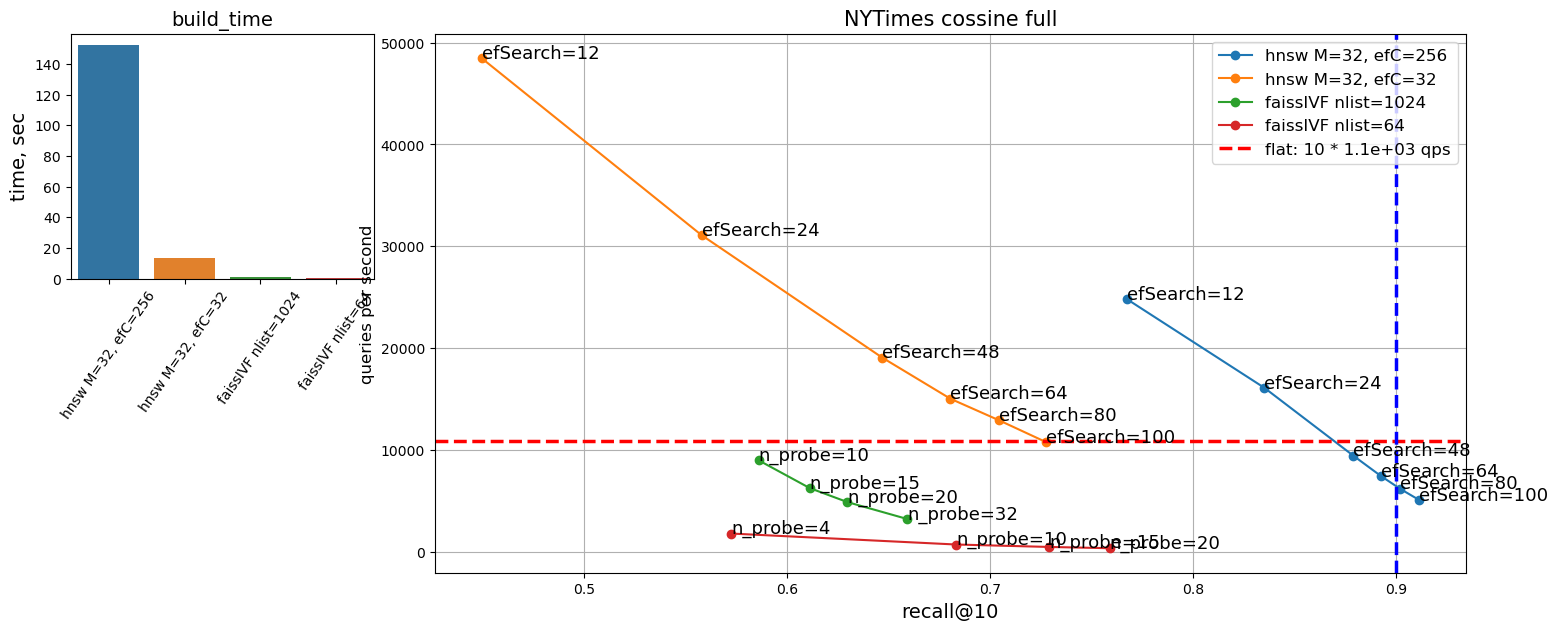

In [20]:
%autoreload 2

X_xk = tr[:]

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_l2,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='NYTimes L2 full',
    recall_line=0.9
)

plot_ann_performance(
    build_data=X_xk,
    query_data=tst,
    index_dict=index_dict_cossine,
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_cosine, 
    query_in_train=False,
    title='NYTimes cossine full',
    recall_line=0.9
)

### Выводы
 - Как видно по графикам, показатели ```cosine``` лучше чем у ```L2``` 

## 2.3 FashionMNIST

Датасет содержит вытянутые в один вектор картинки из датасета [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), с метками

In [33]:
import pandas as pd

tr_df = pd.read_csv('fashion-mnist_train.csv')
tst_df = pd.read_csv('fashion-mnist_test.csv')

tr = tr_df.iloc[:, 1:].values.astype(np.float32)
tst = tst_df.iloc[:, 1:].values.astype(np.float32)

tr_labels = tr_df.iloc[:, 0].values
tst_labels = tst_df.iloc[:, 0].values

num_classes = np.unique(tr_labels).shape[0]

del tr_df, tst_df

dim = tr.shape[1]

tr.shape, tst.shape

((60000, 784), (10000, 784))

**Задание:** выбрать три алгоритма с recall@9 приблизительно 0.6, 0.9, 0.99. Посчитать каждым из этих алгоритмов и алгоритмом точного поиска 9 ближайших по косинусной мере соседей из трейна для всех объектов теста. Предсказать итоговые метки для теста с помощью функции `knn_predict_classification`, померить `sklearn.metrics.balanced_accuracy_score`. Какие выводы можно сделать?

Building flat index....


hnsw M=32, efC=256 || efSearch=100: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]
hnsw M=32, efC=32 || efSearch=100: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]
faissIVF nlist=64 || n_probe=32: 100%|██████████| 5/5 [01:07<00:00, 13.59s/it]
faissIVF nlist=1024 || n_probe=256: 100%|██████████| 9/9 [00:30<00:00,  3.39s/it]
faissIVFPQ nlist=1024 || n_probe=256: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it]


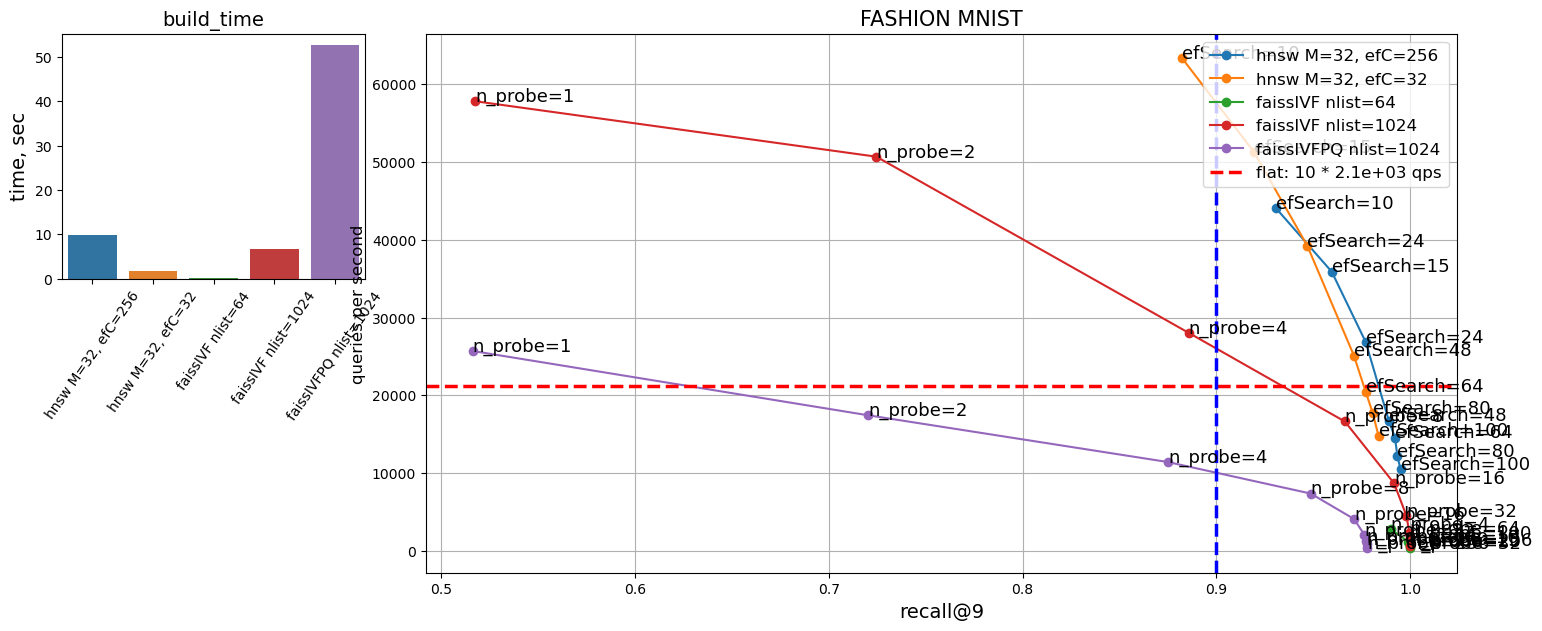

In [14]:
# your code here

%autoreload 2

index_dict = {
    'hnsw M=32, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 32, 'ef_construction': 256, 'num_threads': cpu_count()},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [10, 15, 24, 48, 64, 80, 100]),
        'search_func': search_hnsw
    },
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 32, 'ef_construction': 32, 'num_threads': cpu_count()},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [10, 15, 24, 48, 64, 80, 100]),
        'search_func': search_hnsw
    },


    'faissIVF nlist=64': {
        'fixed_params': {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(), 
            'nlist': 64
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [4, 10, 15, 20, 32]),
        'search_func': search_faiss
    },
    'faissIVF nlist=1024': {
        'fixed_params': {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(), 
            'nlist': 1024
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [1, 2, 4, 8, 16, 32, 64, 100, 256]),
        'search_func': search_faiss
    },


    'faissIVFPQ nlist=1024' : {
        'fixed_params' : {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'm' : 16*7*7, 'nbits' : 8, 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(),
            'nlist': 1024
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [1, 2, 4, 8, 16, 32, 64, 100, 256]),
        'search_func': search_faiss
    }
}

plot_ann_performance(
    build_data=tr,
    query_data=tst,
    index_dict=index_dict,
    k=9,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_cosine,
    query_in_train=False,
    title='FASHION MNIST',
    recall_line=0.9,
    verbose=True,
)

In [43]:
true_index, _ = build_flat_cosine(tr, dim)
_, true_labels, _ = search_cosine(true_index, tst, 9)


params_99 = {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'm' : 16*7*7, 'nbits' : 8, 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(), 'nlist': 1024}
params_90 = {'dim': dim, 'space': 'cosine', 'M': 32, 'ef_construction': 32, 'num_threads': cpu_count()}
params_60 = {'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': cpu_count(), 'nlist': 1024}


alg_60, _ = build_IVFFlat(tr, **params_60) # with nprobe=1
alg_90, _ = build_hnsw(tr, **params_90) # with ef_search=10
alg_99, _ = build_IVFPQ(tr, **params_99) # with n_probe=64
alg100, _ = build_flat_cosine(tr, dim=dim)

In [44]:
d60, l60, _ = search_faiss(alg_60, tst, 9, 1, True)
d90, l90, _ = search_hnsw(alg_90, tst, 9, 10, True)
d99, l99, _ = search_faiss(alg_99, tst, 9, 64, True)
d100, l100, _ = search_cosine(alg100, tst, 9)

In [45]:
from utils.utils import knn_predict_classification

pred60 = knn_predict_classification(l60, tr_labels, num_classes, d60)
pred90 = knn_predict_classification(l90.astype(np.int32), tr_labels, num_classes, d90.astype(np.int32))
pred99 = knn_predict_classification(l99, tr_labels, num_classes, d99)
pred100 = knn_predict_classification(l100, tr_labels, num_classes, d100)

In [46]:
from sklearn.metrics import balanced_accuracy_score as bacc

score60 = bacc(tst_labels, pred60)
score90 = bacc(tst_labels, pred90)
score99 = bacc(tst_labels, pred99)
score100 = bacc(tst_labels, pred100)

print(score60, score90, score99, score100)

0.8265 0.8359000000000002 0.5955 0.8562000000000001


### Выводы 
- Алгоритм, дающий 0.99 recall@9 почему-то отработал хуже всех 0_0. Очень странно, ведь он работает почти как KNN, который выдал 85% accuracy, соответсвенно и метрика должна быть похожа, очень странно.... Видимо PQ плохо для задачи классификации одежды :)
- Алгоритм, дающий 0.6 recall@9 тем не менее не сильно хуже алгоритма с 0.90 recall@9
- Таким образом чем больше aNN походит на kNN, тем лучше он справляется с этой задачей(за исключением PQ)   

# 3. Крабы (6 баллов)

[описание данных](https://www.kaggle.com/datasets/sidhus/crab-age-prediction) <br>
[послать ответ](https://www.kaggle.com/competitions/aim-2023-crabs/leaderboard)

В этом блоке вам предстоит полноценно решить задачу предсказания возраста крабов с помощью ближайших соседей. Данные и информацию о них можно найти по ссылкам выше. Вам нужно скачать данные, предсказать возраст наилучшим способом и отправить в kaggle. **За задание можно получить баллы только в случае побития бейслайна на паблик лидерборде.**

Задание с хорошей вероятностью включает в себя:
- анализ распределений признаков и их физического смысла
- предобработка и трансформация данных
- придумывание и воплощение в жизнь своего видения близости между крабами!
- выбор валидации и тюнинг гиперпараметров
- получение ближайших соседей для теста
- получение предсказаний для теста (проще написать свою функцию, чем разобраться в том, как это сделать через sklearn)

Важно:
- можно использовать любые индексы / методы поиска соседей (но задача спокойно решается полным перебором, так что можно не мудрить)
- можно конструировать дополнительные признаки из имеющихся данных
- нельзя пользоваться никакими другими методами машинного обучения для решения этой задачи (в т.ч. и для генерации признаков)
- нельзя использовать дополнительные данные
- в данном блоке должен быть приведен чистый (без ненужного кода / ячеек) пайплайн работы с данными, который приводит вас от 
    этапа загрузки данных к  получению предсказаний.
    Исследовательская работа, подбор гиперпараметров и прочие вещи выполняйте в другом ноутбуке, который тоже нужно будет 
    прикрепить в классрум
    
**Максимальный балл за задание можно получить за выполнение всех следующих пунктов:**
- побитие бейслайна на kaggle
- наличие в этом ноутбуке адекватного пайплайна (я **не** имею в виду обязательность использования `sklearn.pipeline`!) от начала работы с данными
    до получения предсказаний
- наличие адекватных и в меру развернутых рассуждений на тему того, что вы делаете на каждом этапе и почему


<br><br>

Для начала можно попробовать такой пайплайн:
- `scipy.spatial.distance.cdist` на всех числовых фичах по евклидовой метрике
- `get_k_neighbors` для взятого из головы k
- напишите `knn_predict_regression` по аналогии с классификацией и предскажите тест
- сдайте :)

In [3]:
# your code here
import pandas as pd
import numpy as np

df_train = pd.read_csv('crabs_train.csv')
df_test = pd.read_csv('crabs_test.csv')

df_train

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,F,1.3625,1.0000,0.3625,20.879407,8.703297,5.811648,6.378637,15
1,F,1.4750,1.1250,0.4000,28.576296,10.149121,6.406987,9.638830,13
2,M,1.8750,1.4375,0.5125,62.652395,38.300174,11.708343,14.217274,11
3,F,1.5625,1.1875,0.4250,28.788917,13.182517,5.570677,7.654365,10
4,M,1.5250,1.1625,0.4000,28.760568,15.067759,6.010094,6.846404,8
...,...,...,...,...,...,...,...,...,...
65995,I,0.9750,0.7250,0.2375,9.610480,4.394172,1.800193,2.112038,6
65996,F,1.3000,1.0375,0.3375,18.271253,6.917278,4.224075,5.953395,14
65997,I,0.8750,0.6500,0.2250,5.825822,2.126212,1.048931,1.984465,6
65998,M,1.5625,1.2625,0.3875,31.623867,15.989118,6.789705,8.646598,12


In [4]:
frac = 0.7

train_frac = df_train.sample(frac=frac)
val_frac = df_train.drop(train_frac.index, axis=0)

train, train_labels = train_frac.iloc[:, :-1].reset_index(drop=True), train_frac.iloc[:, -1].reset_index(drop=True)
val, val_labels = val_frac.iloc[:, :-1].reset_index(drop=True), val_frac.iloc[:, -1].reset_index(drop=True)


train.shape, val.shape

((46200, 8), (19800, 8))

In [5]:
!pip install openTSNE

In [6]:
!pip install umap

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from openTSNE import TSNE
import umap
from utils.utils import get_k_neighbors, knn_predict_regression

def split_by_sex(test, train):
    sex_dist = {
        'F' : cdist(test[test['sex'] == 'F'].drop('sex', axis=1).to_numpy(), train[train['sex'] == 'F'].drop('sex', axis=1).to_numpy(), metric='euclidean'),
        'M' : cdist(test[test['sex'] == 'M'].drop('sex', axis=1).to_numpy(), train[train['sex'] == 'M'].drop('sex', axis=1).to_numpy(), metric='euclidean'),
        'I' : cdist(test[test['sex'] == 'I'].drop('sex', axis=1).to_numpy(), train[train['sex'] == 'I'].drop('sex', axis=1).to_numpy(), metric='euclidean'),
    }
    indeces = {
        'F' : test[test['sex'] == 'F'].index.values,
        'M' : test[test['sex'] == 'M'].index.values,
        'I' : test[test['sex'] == 'I'].index.values
    }
    return sex_dist, indeces

def dists2sex(distances_sex, k):
    neighbours = {}
    for s in distances_sex:
        sorted_distances, labels = get_k_neighbors(distances_sex[s], k)
        neighbours[s] = {
            'dists' : sorted_distances,
            'labels' : labels
        }
    return neighbours

def make_preds(d2s, train_labels, w='uniform'):
    preds_sex = {}
    for s in d2s:
        d, l = d2s[s]['dists'], d2s[s]['labels']
        preds_sex[s] = knn_predict_regression(l, train_labels, weights=w, distances=d)
    return preds_sex

def convert(preds_raw, indeces, test_n):
    
    out_df = pd.DataFrame({'age' : np.zeros(test_n)})
    for sp in preds_raw:
        idx = indeces[sp]
        out_df.loc[idx, 'age'] = preds_raw[sp]
    
    return out_df

def pipeline_sex(X_tr, y_tr, test, k, w):
    dist_sex, indeces = split_by_sex(test, X_tr)
    nebs = dists2sex(dist_sex, k)
    preds_raw = make_preds(nebs, y_tr.to_numpy(), w)
    preds = convert(preds_raw, indeces, len(test))
    return preds

def default_transform(df):
    return df.replace({'I' : 0, 'F' : 1, 'M' : 2})

def pipeline_default(X_tr, y_tr, test, k, w):
    dists = cdist(test, X_tr, metric='euclidean')
    sorted_distances, indices = get_k_neighbors(dists, k)
    preds = knn_predict_regression(indices, y_tr, weights=w, distances=sorted_distances)
    return preds

In [8]:
preds_sex = pipeline_sex(train, train_labels, val, 25, w='distance')

In [9]:
# Это пример работы с разделением на пол плохо работает, возможно, я где-то допустил ошибку

error = mean_squared_error(val_labels, preds_sex)
print(error)

10.512588936181523


In [ ]:
train_default, train_default_labels = df_train.drop('age', axis=1), df_train['age'].to_numpy()
test_submit = default_transform(df_test).to_numpy()
preds_default = pipeline_default(
    default_transform(train_default), 
    train_default_labels, 
    test_submit,
    120,
    'distance'
)

In [ ]:
submit_preds = np.round(preds_default)

In [ ]:
submit_df = pd.DataFrame({'age' : submit_preds})
submit_df.to_csv('my_submission_FMI.csv')